<a href="https://colab.research.google.com/github/etokley/stock-prediction-ml-finalproject/blob/master/DeepNeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow.compat.v1 as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")

In [ ]:
!pip install ta

  Created wheel for ta: filename=ta-0.7.0-py3-none-any.whl size=28718 sha256=c4801444aec55a23b767e59d93c3498b5e6a0f08691ce7cc8a82c04a8a942cf4
  Stored in directory: /root/.cache/pip/wheels/5e/74/e0/72395003bd1d3c8f3f5860c2d180ff15699e47a2733d8ebd38
Successfully built ta


In [ ]:
from google.colab import files
file = files.upload()

In [ ]:
df = pd.read_csv('GSPC.csv', parse_dates=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1984-01-03,164.929993,164.929993,163.979996,164.039993,164.039993,71340000
1,1984-01-04,164.089996,166.779999,164.039993,166.779999,166.779999,112980000
2,1984-01-05,166.779999,169.100006,166.779999,168.809998,168.809998,159990000
3,1984-01-06,168.809998,169.309998,168.490005,169.279999,169.279999,137590000
4,1984-01-09,169.179993,169.460007,168.479996,168.899994,168.899994,107100000


In [ ]:
# indicators
import ta
 
RSI = ta.momentum.RSIIndicator(df['Close'])
df['RSI'] = RSI.rsi()
 
StochOscil = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'])
df['StochOscil'] = StochOscil.stoch()
df['StochSignal'] = StochOscil.stoch_signal()
 
df['ADX'] = ta.trend.adx(df['High'], df['Low'], df['Close'])
 
df['MACD_DIFF'] = ta.trend.macd_diff(df['Close'])

In [ ]:
df['Trend'] = 0
for i in range(df.shape[0]-1):
    if i == 0:
        pass
    else:
        if df['Close'][i+1]>df['Close'][i]:
            df['Trend'][i+1] = 1
        else:
            df['Trend'][i+1] = 0

In [ ]:
df.dropna(inplace=True)
df.drop(['Date','Adj Close'], axis=1, inplace=True)

In [ ]:
df.head()

,Open,High,Low,Close,Volume,RSI,StochOscil,StochSignal,ADX,MACD_DIFF,Trend
33,156.130005,156.800003,155.509995,155.740005,76600000,30.035623,16.312065,18.467076,30.448951,-0.221955,0
34,155.710007,155.740005,154.470001,154.639999,71890000,27.413388,5.167115,13.484842,31.528342,-0.214853,0
35,154.520004,155.100006,153.940002,154.309998,90080000,26.661379,3.685221,8.388134,32.713744,-0.198183,0
36,154.020004,154.449997,152.130005,154.289993,100220000,26.613717,18.227761,9.026699,34.361470,-0.156155,0
37,154.309998,157.509995,154.289993,157.509995,102620000,43.974788,61.275520,27.729501,33.534386,0.106690,1


In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1,1))
X = min_max_scaler.fit_transform(df.drop('Trend', axis=1))
# print(X.shape)
y = df[["Trend"]]
# print(y.shape)

In [ ]:
X_train = X[:6329]
X_test = X[6329:]

target_train = y[:6329]
target_test = y[6329:]

In [ ]:
def one_hot_encode(labels):
  n_labels = len(labels)
  n_unique_labels = len(np.unique(labels))
  one_hot_encode = np.zeros((n_labels, n_unique_labels))
  one_hot_encode[np.arange(n_labels), labels] = 1
  return one_hot_encode

In [ ]:
encoder = LabelEncoder()
encoder.fit(target_train)
y_train = encoder.transform(target_train)
y_train = one_hot_encode(y_train)

encoder = LabelEncoder()
encoder.fit(target_test)
y_test = encoder.transform(target_test)
y_test = one_hot_encode(y_test)


In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, target_train.shape, target_test.shape

((6329, 10), (2712, 10), (6329, 2), (2712, 2), (6329, 1), (2712, 1))

In [ ]:
learning_rate = 0.1
training_epochs = 300
cost_history = np.empty(shape=[1],dtype=float)
n_dim = X.shape[1]
n_class = 2

In [ ]:
n_hidden_1 = 300
n_hidden_2 = 200
n_hidden_3 = 100
n_hidden_4 = 50


In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
x = tf.placeholder(tf.float32, [None,n_dim])
w = tf.Variable(tf.zeros([n_dim, n_class]))
b = tf.Variable(tf.zeros(n_class))
y_ = tf.placeholder(tf.float32, [None,n_class])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
def multilayer_perceptron(x, weights, biases):
  layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
  layer_1 = tf.nn.relu(layer_1)

  layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
  layer_2 = tf.nn.relu(layer_2)

  layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
  layer_3 = tf.nn.sigmoid(layer_3)

  layer_4 = tf.add(tf.matmul(layer_3, weights['h4']), biases['b4'])
  layer_4 = tf.nn.sigmoid(layer_4)

  out_layer = tf.matmul(layer_4, weights['out'])+biases['out']
  return out_layer  

In [ ]:
weights = {
    'h1': tf.Variable(tf.truncated_normal([n_dim, n_hidden_1])),
    'h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3])),
    'h4': tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_4])),
    'out': tf.Variable(tf.truncated_normal([n_hidden_4, n_class]))
} 

biases = {
    'b1': tf.Variable(tf.truncated_normal([n_hidden_1])),
    'b2': tf.Variable(tf.truncated_normal([n_hidden_2])),
    'b3': tf.Variable(tf.truncated_normal([n_hidden_3])),
    'b4': tf.Variable(tf.truncated_normal([n_hidden_4])),
    'out': tf.Variable(tf.truncated_normal([n_class]))
}

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

y = multilayer_perceptron(x, weights, biases)

In [ ]:
cost_function = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y, labels=y_))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

In [ ]:
sess = tf.Session()
sess.run(init)

In [ ]:
mse_history = []
accuracy_history = []
train_accuracy_history =[]

for epoch in range(training_epochs):
  sess.run(training_step, feed_dict={x: X_train, y_: y_train})
  cost = sess.run(cost_function, feed_dict={x: X_train, y_: y_train})
  cost_history = np.append(cost_history, cost)
  correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
  # correct_prediction_.append(correct_prediction)
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

  pred_y = sess.run(y, feed_dict={x: X_test})
  mse = tf.reduce_mean(tf.square(pred_y - y_test))
  mse_ = sess.run(mse)
  mse_history.append(mse_)

  train_accuracy = (sess.run(accuracy, feed_dict={x: X_test, y_: y_test}))
  train_accuracy_history.append(train_accuracy)

  accuracy = (sess.run(accuracy, feed_dict={x: X_train, y_: y_train}))
  accuracy_history.append(accuracy)
  print('epoch: ',epoch, '-', 'cost: ',cost, '- MSE: ',mse_, '- Val Accuracy: ',train_accuracy)

epoch:  0 - cost:  1.0528566 - MSE:  5.656008257043014 - Val Accuracy:  0.45427728
epoch:  1 - cost:  0.97215784 - MSE:  4.875536180695957 - Val Accuracy:  0.4741888
epoch:  2 - cost:  0.9219841 - MSE:  4.459901514608899 - Val Accuracy:  0.49151918
epoch:  3 - cost:  0.8771994 - MSE:  4.197245110347318 - Val Accuracy:  0.5036873
epoch:  4 - cost:  0.8406085 - MSE:  4.031267658346456 - Val Accuracy:  0.5143805
epoch:  5 - cost:  0.8091053 - MSE:  3.8978814636495525 - Val Accuracy:  0.5221239
epoch:  6 - cost:  0.7818885 - MSE:  3.780315851848107 - Val Accuracy:  0.5287611
epoch:  7 - cost:  0.7581414 - MSE:  3.6910621635147867 - Val Accuracy:  0.5243363
epoch:  8 - cost:  0.7405158 - MSE:  3.612632854497862 - Val Accuracy:  0.5283923
epoch:  9 - cost:  0.7256685 - MSE:  3.539617205988827 - Val Accuracy:  0.5265487
epoch:  10 - cost:  0.71655786 - MSE:  3.4681856772568636 - Val Accuracy:  0.5291298
epoch:  11 - cost:  0.71076626 - MSE:  3.409031755122042 - Val Accuracy:  0.53097343
epoch

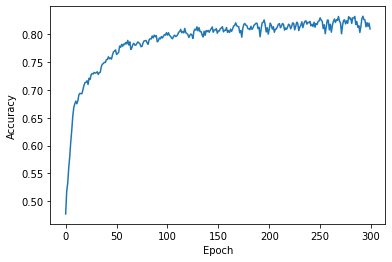

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(accuracy_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
plt.plot(train_accuracy_history, 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [12]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Test Accuracy: ', (sess.run(accuracy, feed_dict={x: X_test, y_: y_test})))

Test Accuracy: 0.779867257


In [ ]:
correct_prediction = tf.argmax(y,1)
pred = tf.cast(correct_prediction, tf.float32)
ann_pred = sess.run(pred, feed_dict={x: X_test, y_: y_test})
print('Predicted Classes: ', ann_pred)

Predicted Classes:  [1. 1. 1. ... 0. 0. 0.]


## Logistic Regression

In [ ]:
# scale = MinMaxScaler(feature_range=(-1,1))
# data = scale.fit_transform(df.drop('Trend', axis=1))
# target = df['Trend'].values

# x_train, x_test, target_train, target_test = train_test_split(data, target, test_size=0.3, random_state = 21)

from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
logit.fit(X_train, target_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = logit.predict(X_test)
logit.score(X_test, target_test)

0.8241150442477876

## Metrics from Logistic Regression

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(target_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.73      0.79      1220
           1       0.80      0.90      0.85      1492

    accuracy                           0.82      2712
   macro avg       0.83      0.82      0.82      2712
weighted avg       0.83      0.82      0.82      2712



In [ ]:
conf_matrix = confusion_matrix(target_test,y_pred)
print(conf_matrix)

[[ 886  334]
 [ 143 1349]]


In [ ]:
print('Precision of lr: {}'.format(1349/(1349+334)))
print('Recall of lr: {}'.format(1349/(1349+143)))

Precision of lr: 0.8015448603683898
Recall of lr: 0.9041554959785523


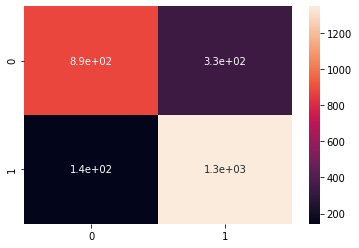

In [ ]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True)

In [ ]:
target_test.shape

(2712, 1)